In [1]:
import numpy as np
import sklearn.preprocessing as prep
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                             minval = low, maxval = high,
                             dtype = tf.float32)


In [3]:
class AdditiveGaussianNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function = tf.nn.softplus, optimizer = tf.train.AdamOptimizer(),
                 scale = 0.1):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.scale = tf.placeholder(tf.float32)
        self.training_scale = scale
        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        
        #self.hidden = self.transfer(tf.add(tf.matmul(self.x + scale * tf.random_normal((n_input,)),
        #        self.weights['w1']),
        #        self.weights['b1']))
        self.hidden = self.transfer(tf.add(tf.matmul(self.x,
                self.weights['w1']),
                self.weights['b1']))
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype = tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype = tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype = tf.float32))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict = {self.x: X,
                                                                            self.scale: self.training_scale
                                                                            })
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X,
                                                     self.scale: self.training_scale
                                                     })

    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict = {self.x: X,
                                                       self.scale: self.training_scale
                                                       })

    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.normal(size = self.weights["b1"])
        return self.sess.run(self.reconstruction, feed_dict = {self.hidden: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict = {self.x: X,
                                                               self.scale: self.training_scale
                                                               })

    def getWeights1(self):
        return self.sess.run(self.weights['w1'])

    def getBiases1(self):
        return self.sess.run(self.weights['b1'])
    
    def getWeights2(self):
        return self.sess.run(self.weights['w2'])

    def getBiases2(self):
        return self.sess.run(self.weights['b2'])

In [4]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

def standard_scale(X_train, X_test):
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)]

X_train, X_test = standard_scale(mnist.train.images, mnist.test.images)

n_samples = int(mnist.train.num_examples)
training_epochs = 20
batch_size = 128
display_step = 1

autoencoder = AdditiveGaussianNoiseAutoencoder(n_input = 784,
                                               n_hidden = 100,
                                               transfer_function = tf.nn.softplus,
                                               optimizer = tf.train.AdamOptimizer(learning_rate = 0.001),
                                               scale = 0.01)

for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = get_random_block_from_data(X_train, batch_size)

        # Fit training using batch data
        cost = autoencoder.partial_fit(batch_xs)
        # Compute average loss
        avg_cost += cost / n_samples * batch_size

    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

print("Total cost: " + str(autoencoder.calc_total_cost(X_test)))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 0001 cost= 22362.442827273
Epoch: 0002 cost= 16387.386143182
Epoch: 0003 cost= 16771.719356818
Epoch: 0004 cost= 15269.029589773
Epoch: 0005 cost= 15855.603161364
Epoch: 0006 cost= 15579.469003409
Epo

In [8]:
img =   mnist.train.images[0]
img.shape

(784,)

In [9]:
b_IMAGE1 = autoencoder.getBiases1()
W_IMAGE1 = autoencoder.getWeights1()

b_IMAGE2 = autoencoder.getBiases2()
W_IMAGE2 = autoencoder.getWeights2()

In [10]:

#W_IMAGE = np.multiply(np.mat(W_IMAGE1),np.mat(W_IMAGE2))
W_IMAGE = (np.mat(img) * np.mat(W_IMAGE1) + b_IMAGE1) * np.mat(W_IMAGE2) + b_IMAGE2

In [11]:
W_IMAGE = (np.mat(W_IMAGE1) + b_IMAGE1) * np.mat(W_IMAGE2) + b_IMAGE2

In [12]:
W_IMAGE = (np.mat(W_IMAGE1) + b_IMAGE1)

In [13]:
W_IMAGE = W_IMAGE1

In [14]:
W_IMAGE1.shape ,b_IMAGE1.shape, W_IMAGE2.shape , b_IMAGE2.shape

((784, 100), (100,), (100, 784), (784,))

In [15]:
np.mat(W_IMAGE1).shape

(784, 100)

In [16]:
W_IMAGE.shape

(784, 100)

In [17]:
W_IMAGE[:,0].shape

(784,)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
WW_narray1 = W_IMAGE[:,9].reshape(28,28)
WW_narray1

array([[ 5.74455410e-03, -6.69135302e-02, -5.32850623e-03,
         7.09928721e-02,  1.30860656e-02,  5.95733076e-02,
         6.07901961e-02, -6.05935790e-02,  1.84917748e-02,
         8.46607238e-03,  1.51963830e-02, -1.66962296e-03,
        -1.52526021e+00, -1.52607751e+00, -1.51375175e+00,
        -1.62663102e+00,  1.06083676e-02, -4.88900617e-02,
        -3.39612365e-04,  3.77439708e-02, -3.47659253e-02,
        -6.83673844e-02, -4.54872921e-02,  7.11115450e-03,
         6.33916706e-02, -5.23453578e-02, -4.22639512e-02,
         1.83735639e-02],
       [ 5.13285846e-02,  7.33979195e-02,  6.44418150e-02,
        -2.74829380e-02, -1.52465117e+00, -1.50259507e+00,
        -1.60532939e+00,  6.47829380e-03,  2.07766015e-02,
         3.25693488e-02,  8.29353854e-02,  9.73858088e-02,
         4.54226509e-02, -1.02333920e-02, -5.15653640e-02,
        -6.31213188e-02, -6.20011926e-01, -4.22072709e-01,
        -2.72178113e-01, -8.95100415e-01, -1.53707647e+00,
        -1.49039006e+00, -1.62

0


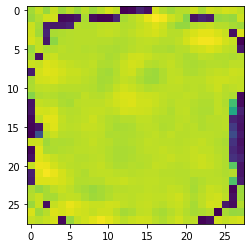

1


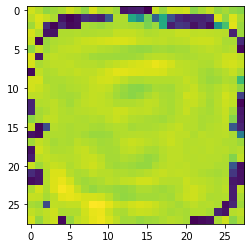

2


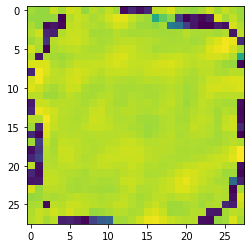

3


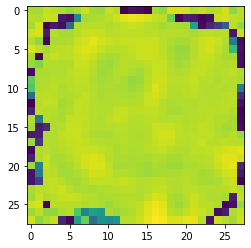

4


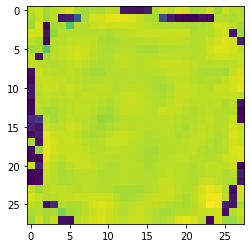

5


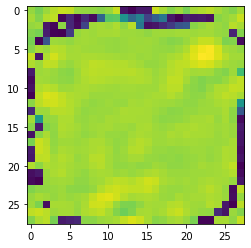

6


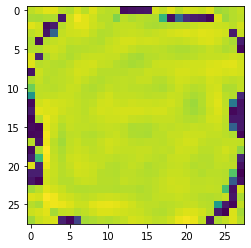

7


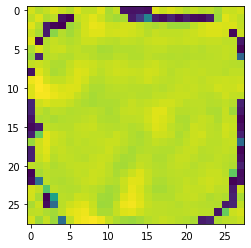

8


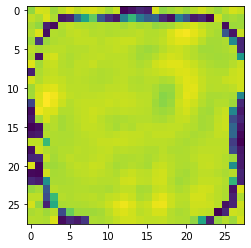

9


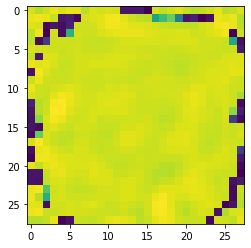

10


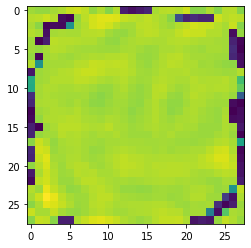

11


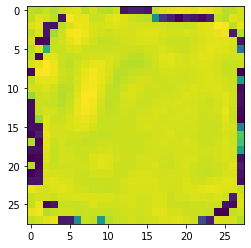

12


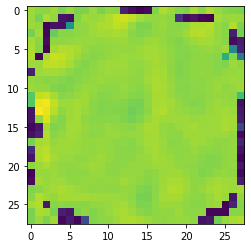

13


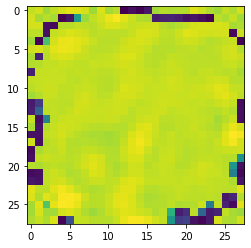

14


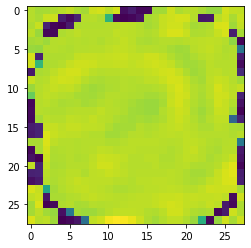

15


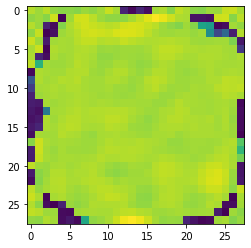

16


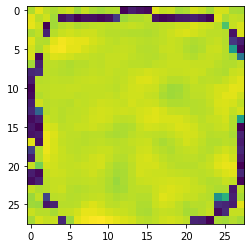

17


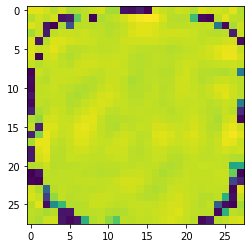

18


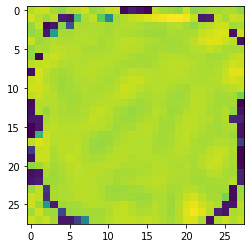

19


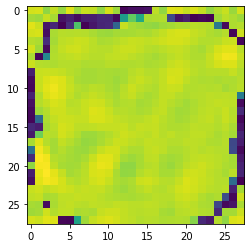

20


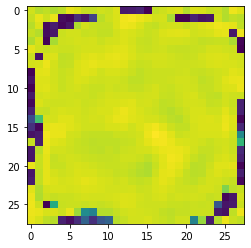

21


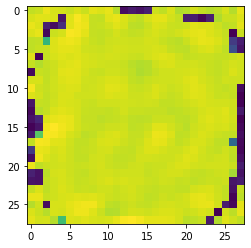

22


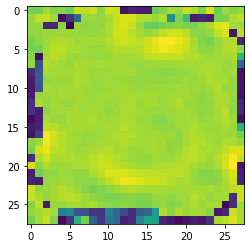

23


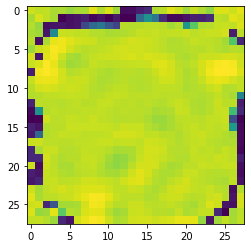

24


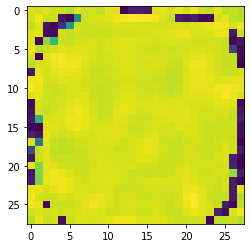

25


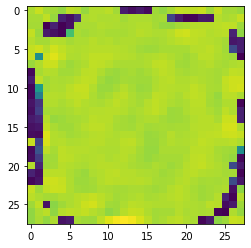

26


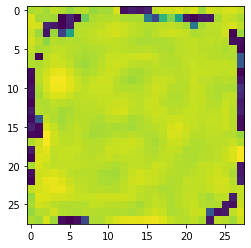

27


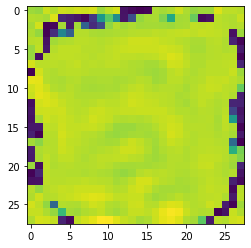

28


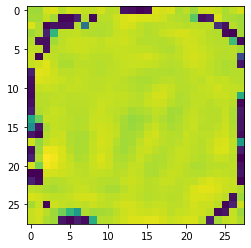

29


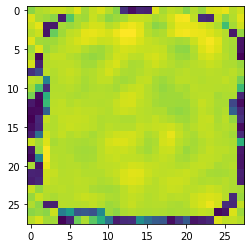

30


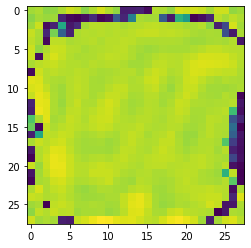

31


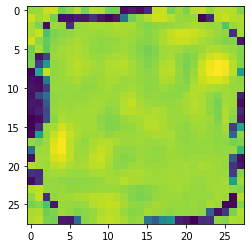

32


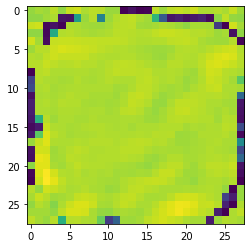

33


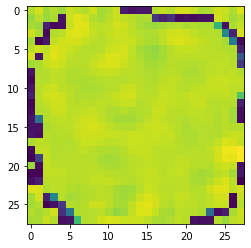

34


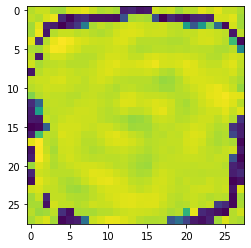

35


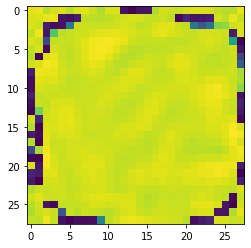

36


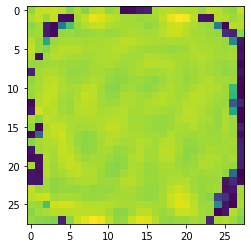

37


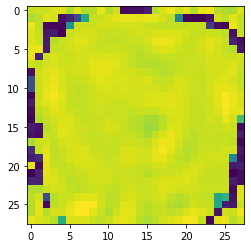

38


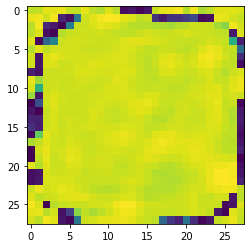

39


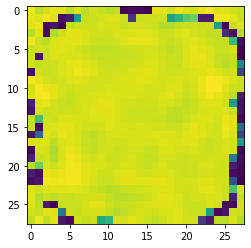

40


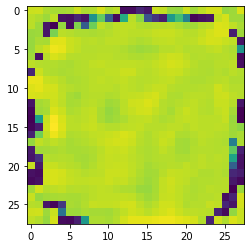

41


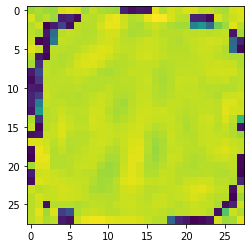

42


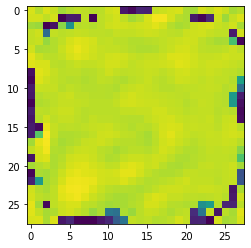

43


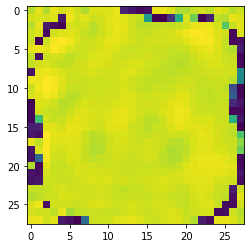

44


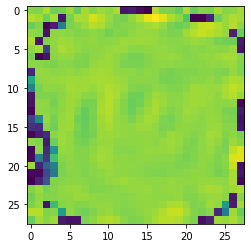

45


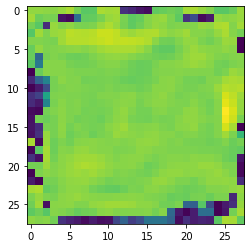

46


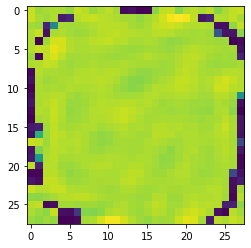

47


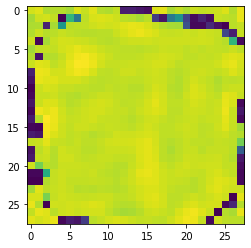

48


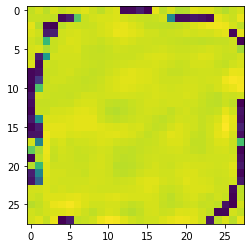

49


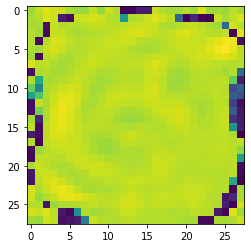

50


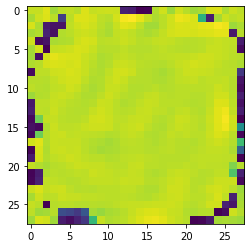

51


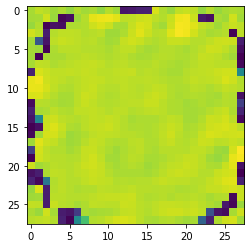

52


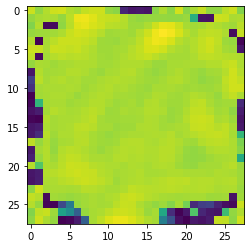

53


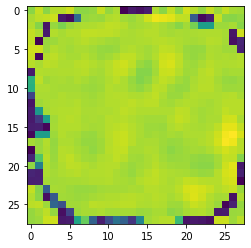

54


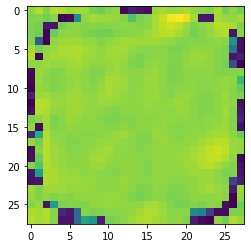

55


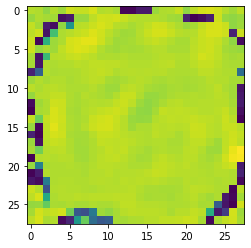

56


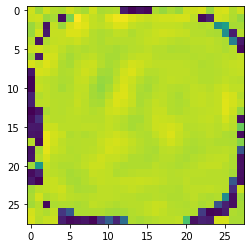

57


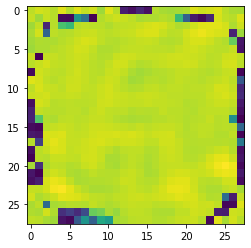

58


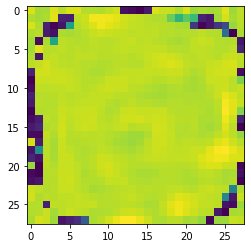

59


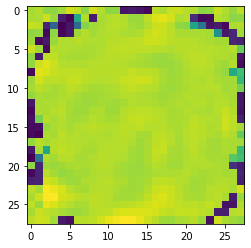

60


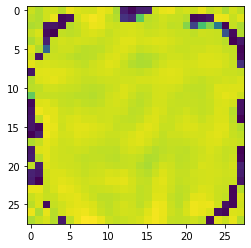

61


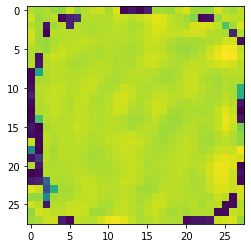

62


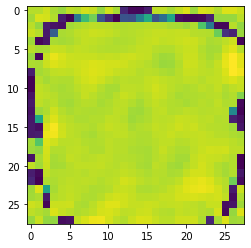

63


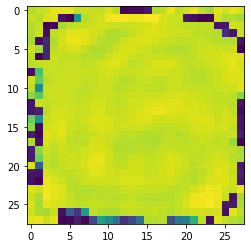

64


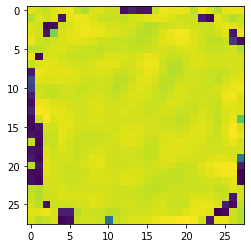

65


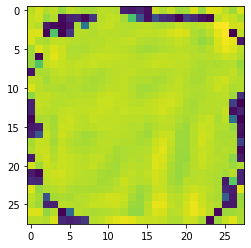

66


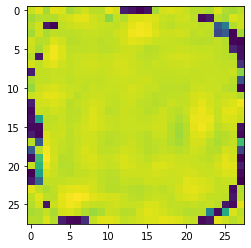

67


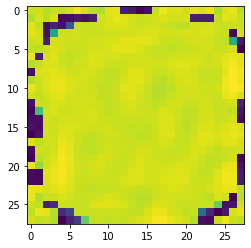

68


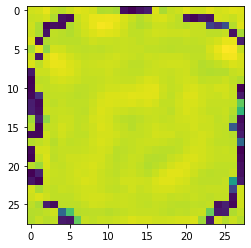

69


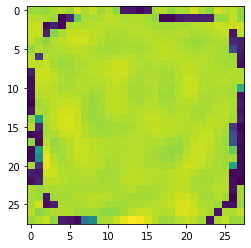

70


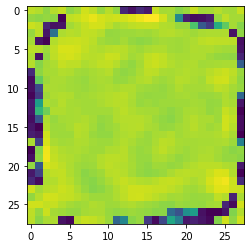

71


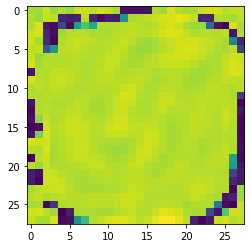

72


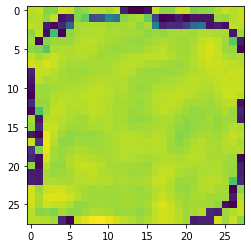

73


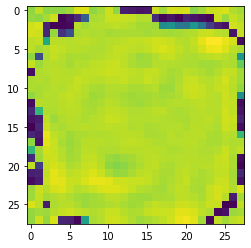

74


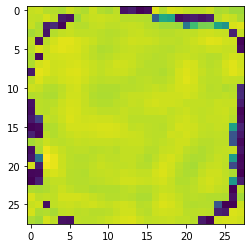

75


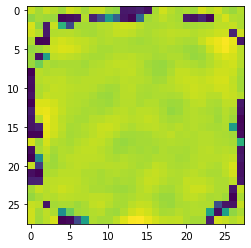

76


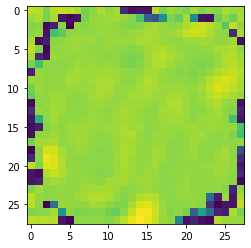

77


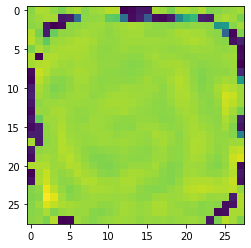

78


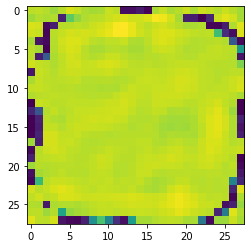

79


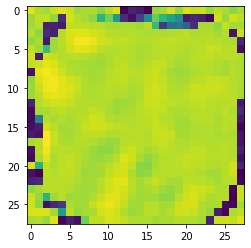

80


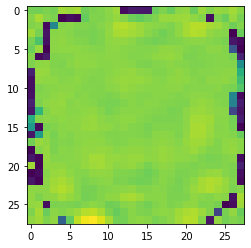

81


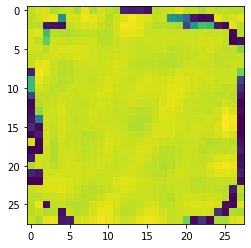

82


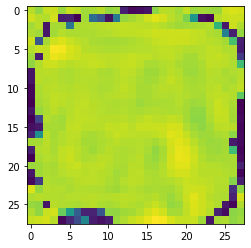

83


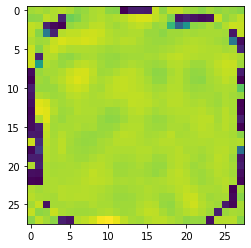

84


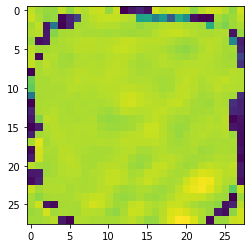

85


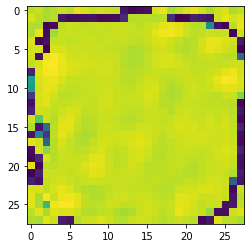

86


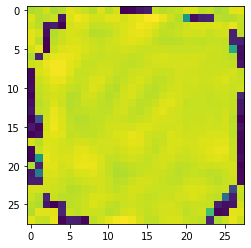

87


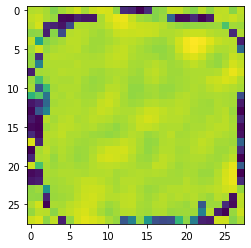

88


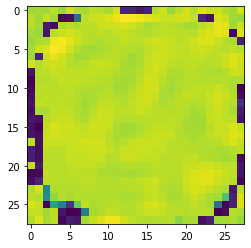

89


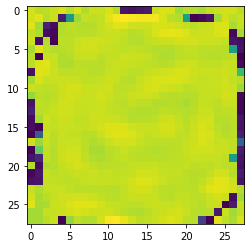

90


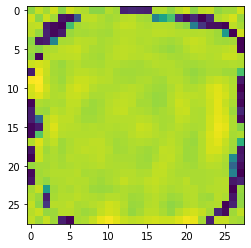

91


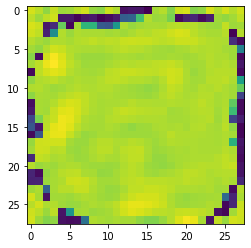

92


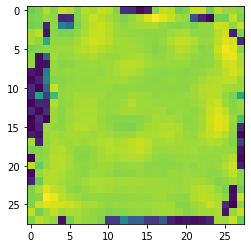

93


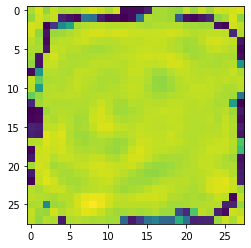

94


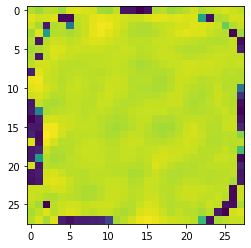

95


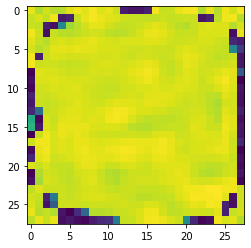

96


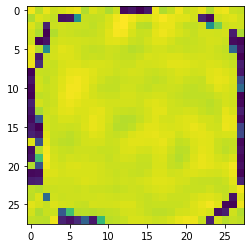

97


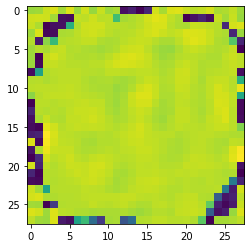

98


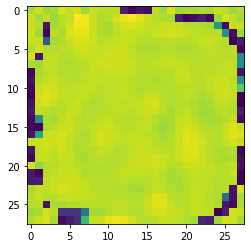

99


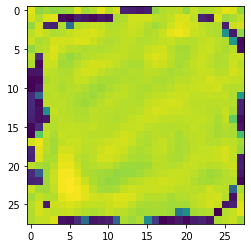

In [19]:
for i in range(100):
    print(i)
    WW_narray1 = W_IMAGE[:,i].reshape(28,28)
    plt.figure()
    plt.imshow(WW_narray1)
    plt.show()

0


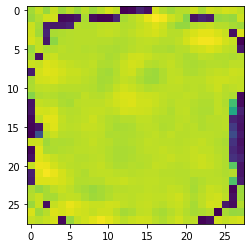

1


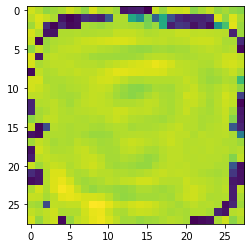

2


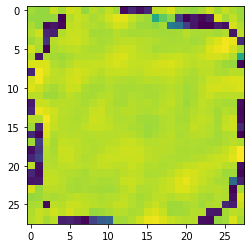

3


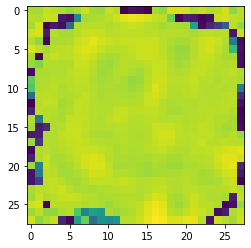

4


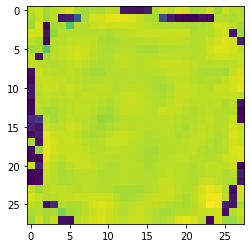

5


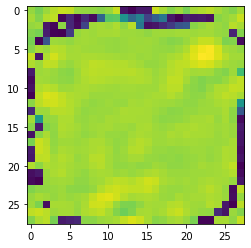

6


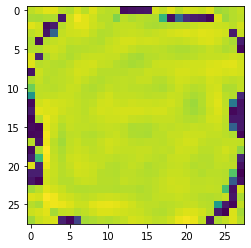

7


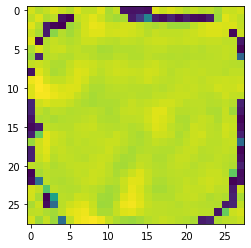

8


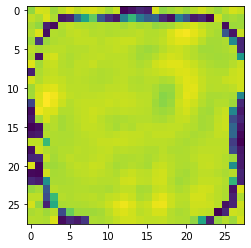

9


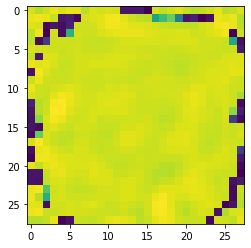

10


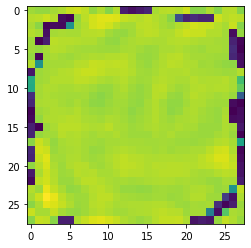

11


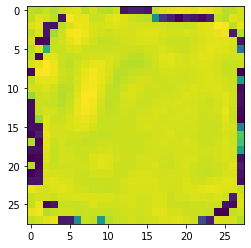

12


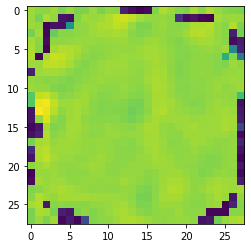

13


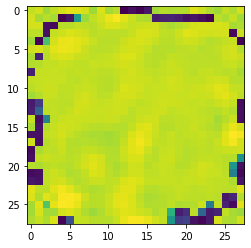

14


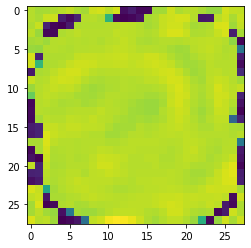

15


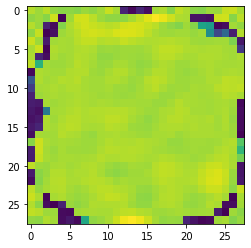

16


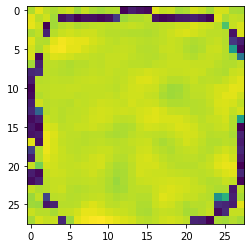

17


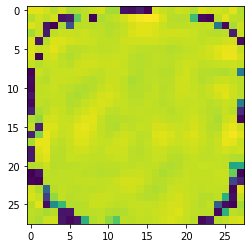

18


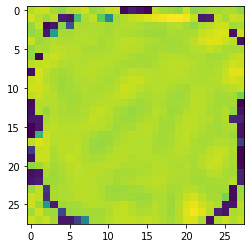

19


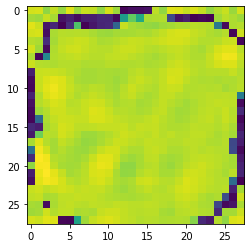

20


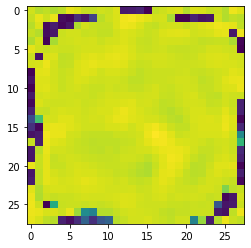

21


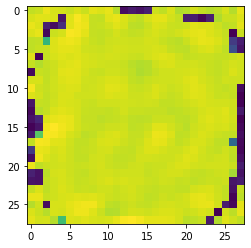

22


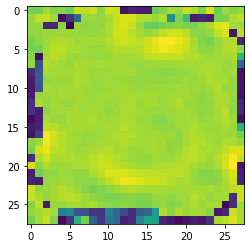

23


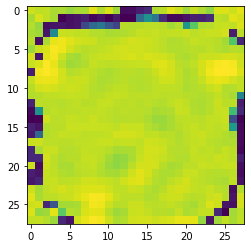

24


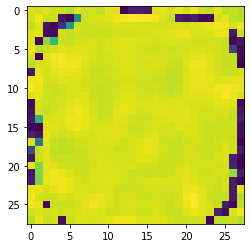

25


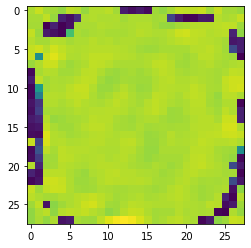

26


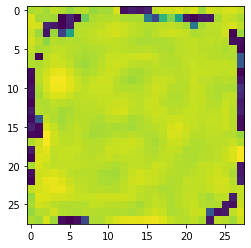

27


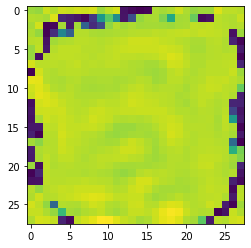

28


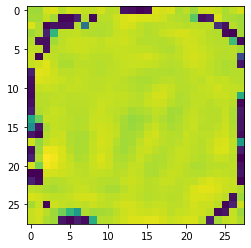

29


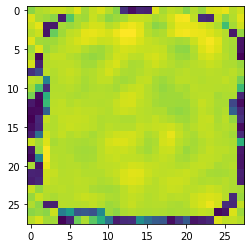

30


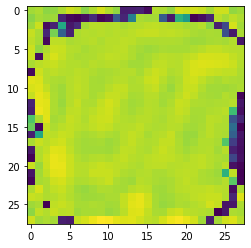

31


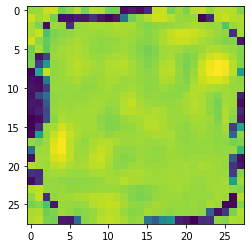

32


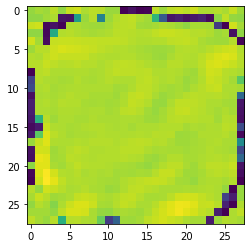

33


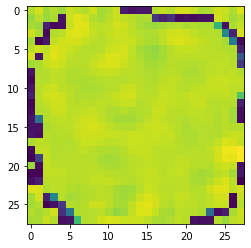

34


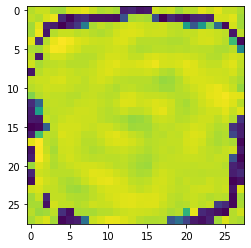

35


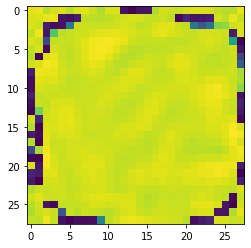

36


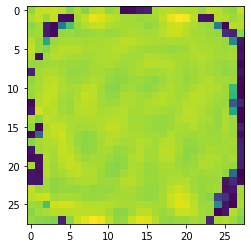

37


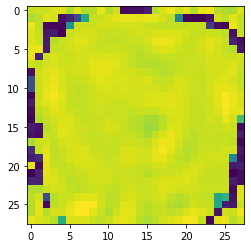

38


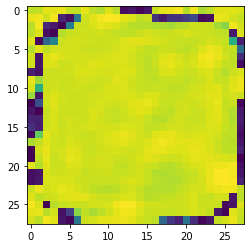

39


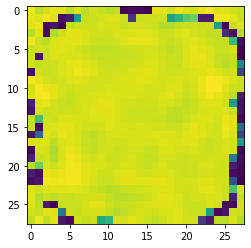

40


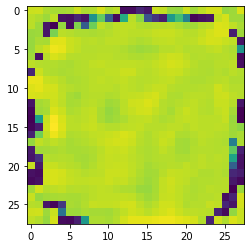

41


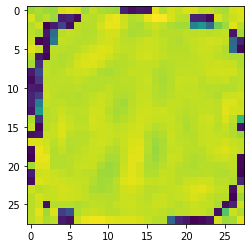

42


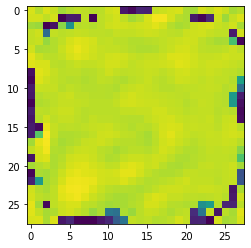

43


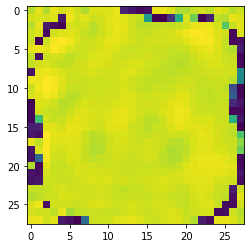

44


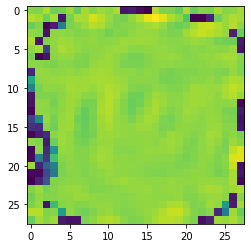

45


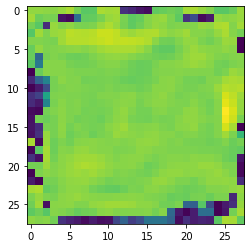

46


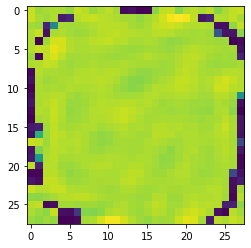

47


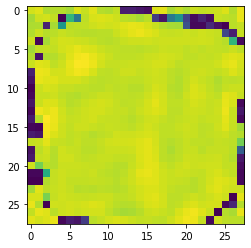

48


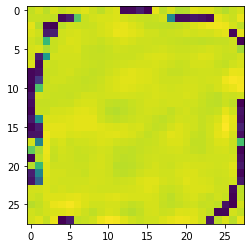

49


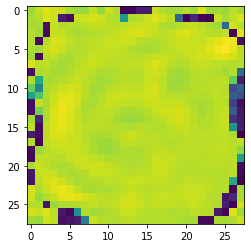

50


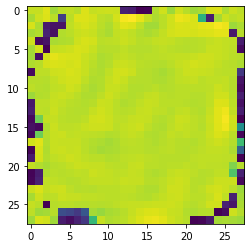

51


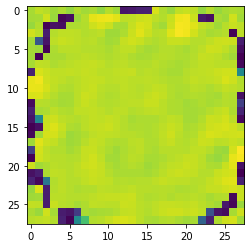

52


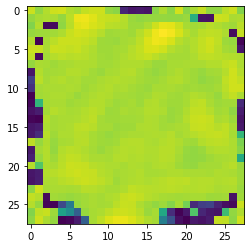

53


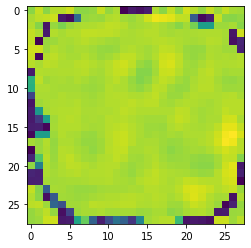

54


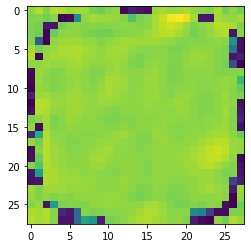

55


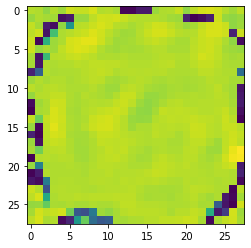

56


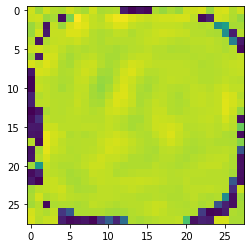

57


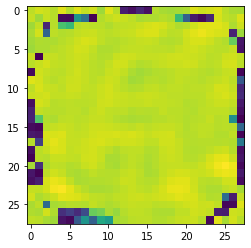

58


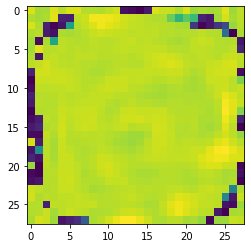

59


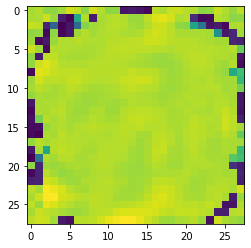

60


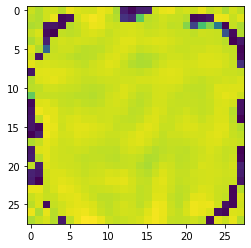

61


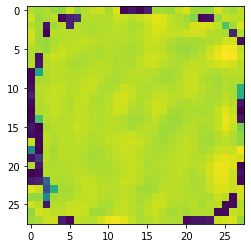

62


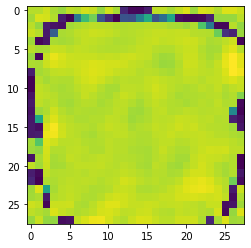

63


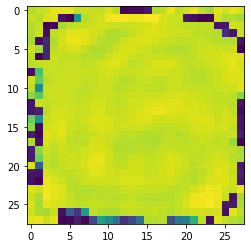

64


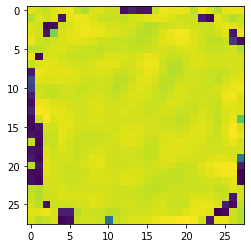

65


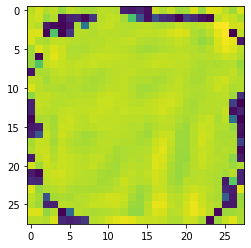

66


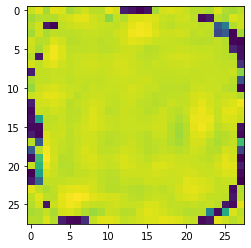

67


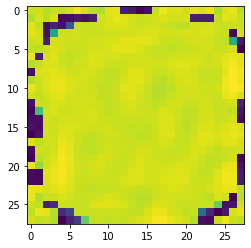

68


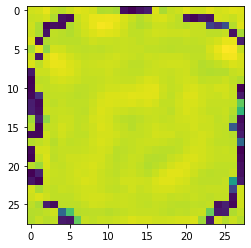

69


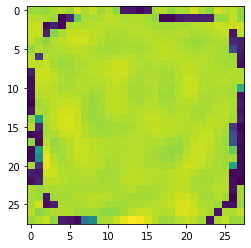

70


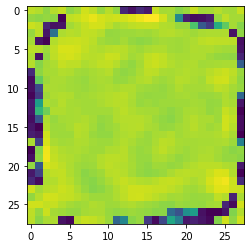

71


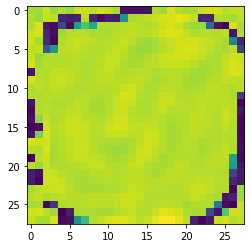

72


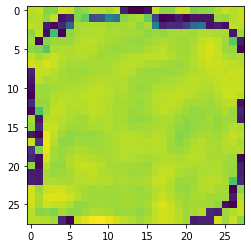

73


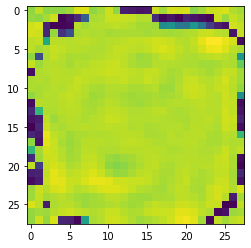

74


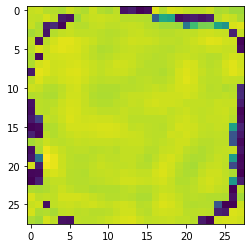

75


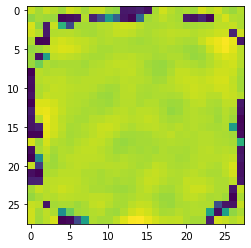

76


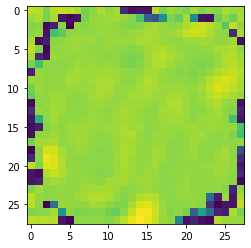

77


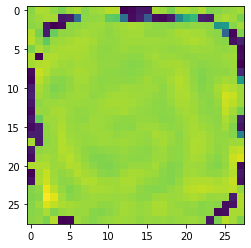

78


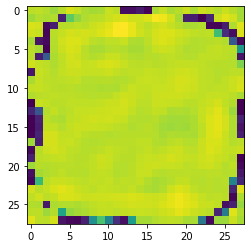

79


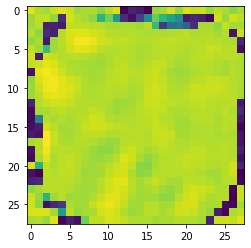

80


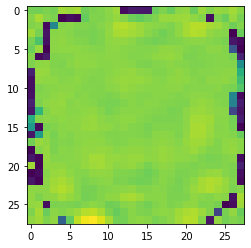

81


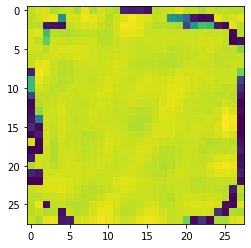

82


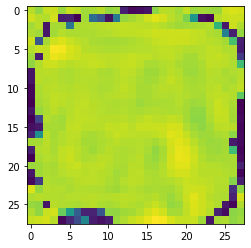

83


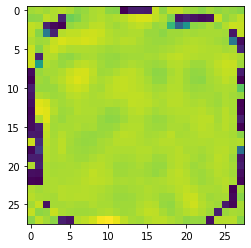

84


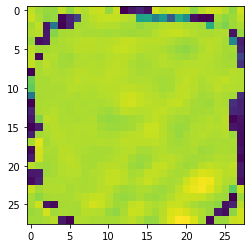

85


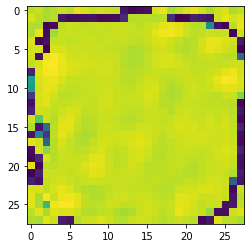

86


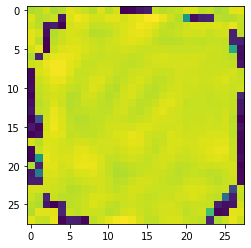

87


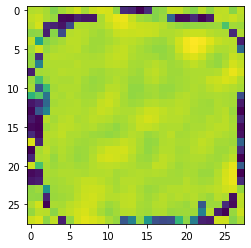

88


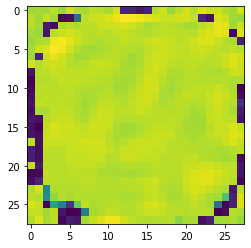

89


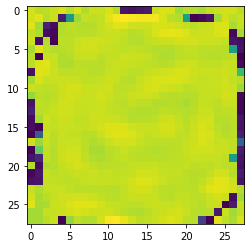

90


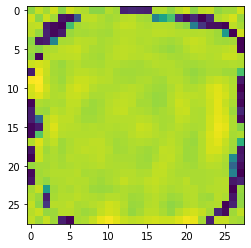

91


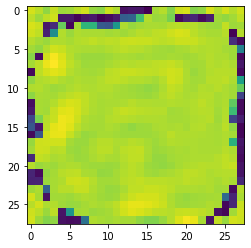

92


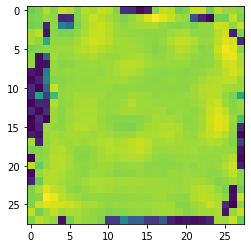

93


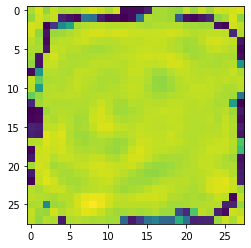

94


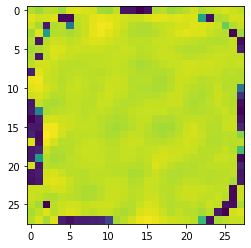

95


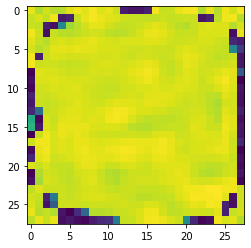

96


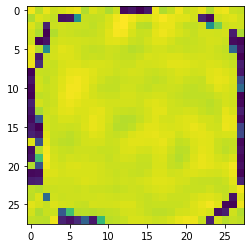

97


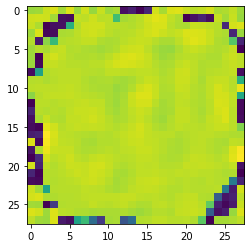

98


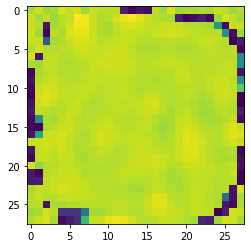

99


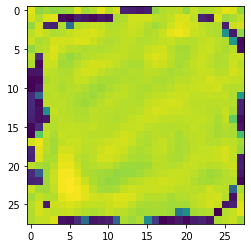

In [20]:
for i in range(100):
    print(i)
    WW_narray1 = W_IMAGE[:,i].reshape(28,28)
    plt.figure()
    plt.imshow(WW_narray1)
    plt.show()

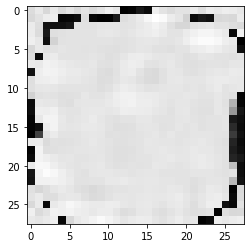

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(W_IMAGE[:,0].reshape(784,1).reshape(28,28),"gray")
plt.show()

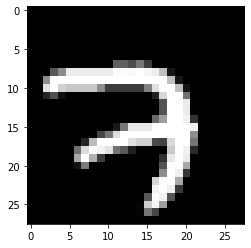

In [22]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(img.reshape(784,1).reshape(28,28),"gray")
plt.show()

In [23]:
W_IMAGE.shape

(784, 100)

In [24]:
W_IMAGE.reshape(1,784*100).reshape(28,28*100)

array([[-0.05034044,  0.04711784, -0.04008436, ..., -0.06662153,
        -0.02246761, -0.06710869],
       [-0.06935996,  0.01221032, -0.06137367, ..., -0.07937362,
        -0.05255748,  0.01197261],
       [ 0.04250571, -0.03857584, -0.0241717 , ...,  0.07179159,
         0.04303949,  0.04497257],
       ...,
       [-0.06615975, -0.02388689, -0.0210771 , ...,  0.02490976,
        -0.03800517,  0.06740595],
       [ 0.07134302,  0.01651768, -0.0113451 , ...,  0.06533667,
         0.03505085,  0.07522944],
       [ 0.02692477,  0.05006525,  0.00013669, ..., -0.00109171,
        -0.04821007, -0.04833468]], dtype=float32)

In [25]:
autoencoder.sess.run(autoencoder.reconstruction)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [?,784]
	 [[node Placeholder_1 (defined at C:\Anaconda3\envs\python36\lib\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]

Original stack trace for 'Placeholder_1':
  File "C:\Anaconda3\envs\python36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\envs\python36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\envs\python36\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Anaconda3\envs\python36\lib\site-packages\ipykernel\kernelapp.py", line 583, in start
    self.io_loop.start()
  File "C:\Anaconda3\envs\python36\lib\site-packages\tornado\platform\asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "C:\Anaconda3\envs\python36\lib\asyncio\base_events.py", line 442, in run_forever
    self._run_once()
  File "C:\Anaconda3\envs\python36\lib\asyncio\base_events.py", line 1462, in _run_once
    handle._run()
  File "C:\Anaconda3\envs\python36\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Anaconda3\envs\python36\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Anaconda3\envs\python36\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Anaconda3\envs\python36\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Anaconda3\envs\python36\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Anaconda3\envs\python36\lib\site-packages\ipykernel\kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Anaconda3\envs\python36\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Anaconda3\envs\python36\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Anaconda3\envs\python36\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Anaconda3\envs\python36\lib\site-packages\ipykernel\kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "C:\Anaconda3\envs\python36\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Anaconda3\envs\python36\lib\site-packages\ipykernel\ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Anaconda3\envs\python36\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Anaconda3\envs\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Anaconda3\envs\python36\lib\site-packages\IPython\core\interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "C:\Anaconda3\envs\python36\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Anaconda3\envs\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Anaconda3\envs\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Anaconda3\envs\python36\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-3c92bd42e281>", line 24, in <module>
    scale = 0.01)
  File "<ipython-input-3-2e511a5a9206>", line 13, in __init__
    self.x = tf.placeholder(tf.float32, [None, self.n_input])
  File "C:\Anaconda3\envs\python36\lib\site-packages\tensorflow_core\python\ops\array_ops.py", line 2619, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Anaconda3\envs\python36\lib\site-packages\tensorflow_core\python\ops\gen_array_ops.py", line 6669, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Anaconda3\envs\python36\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "C:\Anaconda3\envs\python36\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Anaconda3\envs\python36\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "C:\Anaconda3\envs\python36\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "C:\Anaconda3\envs\python36\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
